# Fraud Data Preprocessing Pipeline (from raw data to model-ready dataframe)

#### Creating a synthetic dataset to simulate the fraud detection data preprocessing pipeline.

In this approach we will conduct a real world fraud detection preprocessing simulation. For this, we're using a synthetic dataset that mimics real-world bank transactions.

The dataset includes demographic, financial, and behavioral attributes, along with a binary target variable (1 = fraud, 0 = legitimate).

Data preprocessing includes:

- Handling missing values
- Normalizing numeric features
- Encoding categorical variables
- Creating and selecting the most relevant features (Feature Engineering)
- Dimensionality reduction using PCA

These steps ensure data quality and improve model performance.

## 1. Importing the libraries

In [36]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

## 2. Simulating a raw dataset

To create a fake raw dataset that simulates real-world bank transactions, we will use numpy and pandas.

In [37]:
np.random.seed(42)  # for reproducibility

n = 10000  # number of samples

def random_date_range(start, periods, min_gap='30s', max_gap='10min', tz=None, seed=42):
    """
    Create a DatetimeIndex starting at `start` with `periods` timestamps.
    Each consecutive timestamp is advanced by a random gap uniformly sampled
    between min_gap and max_gap (inclusive).
    """
    if periods < 1:
        raise ValueError("periods must be >= 1")
    min_td = pd.Timedelta(min_gap)
    max_td = pd.Timedelta(max_gap)
    if min_td > max_td:
        raise ValueError("min_gap must be <= max_gap")

    rng = np.random.default_rng(seed)
    if periods == 1:
        return pd.DatetimeIndex([pd.Timestamp(start, tz=tz)])

    # sample gaps in nanoseconds (inclusive of bounds)
    low = min_td.value
    high = max_td.value
    gaps = rng.integers(low=low, high=high + 1, size=periods - 1, dtype=np.int64)
    offsets = np.concatenate([[0], np.cumsum(gaps)])
    start_ts = pd.Timestamp(start, tz=tz)
    return pd.DatetimeIndex(start_ts.value + offsets).tz_localize('UTC' if start_ts.tz is None else None).tz_convert(tz) if tz else pd.DatetimeIndex(start_ts.value + offsets)

raw_df = pd.DataFrame({
    'transaction_id': np.arange(n),
    'datetime': random_date_range('2024-01-01', n, min_gap='30s', max_gap='10min'),
    'amount': np.random.exponential(scale=100, size=n).round(2),
    'country': np.random.choice(['Brazil', 'USA', 'UK', 'Germany'], n),
    'city': np.random.choice(['Rio', 'New York', 'London', 'Berlin'], n),
    'district': np.random.choice(['Center', 'North', 'South', 'West'], n),
    'zip': np.random.randint(10000, 99999, n),
    'ip': [f"192.168.{np.random.randint(0,255)}.{np.random.randint(0,255)}" for _ in range(n)],
    'os': np.random.choice(['Windows', 'Android', 'iOS'], n),
    'background_checks': np.random.randint(0, 5, n),
    'complaints': np.random.randint(0, 10, n),
    'transactions': np.random.randint(1, 50, n),
    'credit_score': np.random.normal(650, 100, n).astype(int),
    'credit_limit': np.random.uniform(500, 20000, n).round(2),
    'device': np.random.choice(['mobile', 'desktop'], n),
    'browser': np.random.choice(['Chrome', 'Safari', 'Firefox', 'Edge'], n),
    'is_fraud': np.random.choice([0, 1], n, p=[0.985, 0.015])  # imbalanced target
})

display("Raw dataset sample:")
display(raw_df.sample(5))

'Raw dataset sample:'

,transaction_id,datetime,amount,country,city,district,zip,ip,os,background_checks,complaints,transactions,credit_score,credit_limit,device,browser,is_fraud
1250,1250,2024-01-05 12:54:59.023225398,159.23,USA,Berlin,Center,31219,192.168.74.205,iOS,4,9,42,656,942.55,desktop,Chrome,0
4688,4688,2024-01-17 23:51:35.238883988,78.58,UK,Berlin,Center,85131,192.168.8.1,iOS,4,7,2,727,14631.29,desktop,Edge,0
1528,1528,2024-01-06 13:40:29.915785553,162.47,UK,New York,South,59349,192.168.161.220,iOS,1,9,17,733,13946.66,mobile,Firefox,0
3808,3808,2024-01-14 20:47:31.319955578,5.17,UK,Rio,North,94192,192.168.191.79,iOS,3,7,22,539,13957.78,mobile,Chrome,0
4558,4558,2024-01-17 12:49:05.140600606,268.44,UK,New York,West,63734,192.168.84.215,Windows,4,6,47,630,3367.41,desktop,Edge,0


## 3. Feature Engineering

To enrich the dataset with additional features, we can perform feature engineering. This can include creating new features from existing data, such as time-based features, transaction amount-based features, or other relevant features.

In this case we will create a 'time' feature with the number of seconds elapsed between each transaction and the first transaction in the dataset.

We will also split datetime column into day and hour columns and drop the original datetime column to reduce the dimensionality of the dataset.

In [38]:
# --- 3. Feature extraction from datetime ---

# Create 'time' feature 
raw_df.loc[:, 'time'] = raw_df['datetime'].apply(lambda x: (x - raw_df['datetime'].iloc[0]).seconds)

# Split 'datetime' in 'day' and 'hour'
raw_df['day'] = raw_df['datetime'].dt.day
raw_df['hour'] = raw_df['datetime'].dt.hour
# raw_df['minute'] = raw_df['datetime'].dt.minute

# Drop original datetime column
raw_df.drop(columns=['datetime'], inplace=True)
raw_df.head()

,transaction_id,amount,country,city,district,zip,ip,os,background_checks,complaints,transactions,credit_score,credit_limit,device,browser,is_fraud,time,day,hour
0,0,46.93,UK,Berlin,North,23849,192.168.146.74,Android,1,7,47,606,14481.56,desktop,Chrome,0,0,1,0
1,1,301.01,Germany,New York,North,29344,192.168.216.0,iOS,1,2,24,512,11436.06,desktop,Chrome,0,471,1,0
2,2,131.67,Germany,Rio,West,31214,192.168.159.212,Windows,0,8,46,751,15843.76,mobile,Chrome,0,751,1,0
3,3,91.29,USA,Berlin,Center,48226,192.168.108.76,iOS,3,4,16,611,12256.27,mobile,Edge,0,1270,1,0
4,4,16.96,Brazil,Rio,Center,32522,192.168.161.16,iOS,4,5,29,764,19257.12,mobile,Firefox,0,1698,1,0


Creating a **"security index"** feature based on the background checks and complaints and a **"average value"** of transactions.

In [39]:
raw_df['security_index'] = raw_df['background_checks'] * 0.7 + raw_df['complaints'] * 0.3
raw_df['avg_value_per_tx'] = raw_df['amount'] / raw_df['transactions']

Checking summary of dataset.

In [40]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   amount             10000 non-null  float64
 2   country            10000 non-null  object 
 3   city               10000 non-null  object 
 4   district           10000 non-null  object 
 5   zip                10000 non-null  int64  
 6   ip                 10000 non-null  object 
 7   os                 10000 non-null  object 
 8   background_checks  10000 non-null  int64  
 9   complaints         10000 non-null  int64  
 10  transactions       10000 non-null  int64  
 11  credit_score       10000 non-null  int64  
 12  credit_limit       10000 non-null  float64
 13  device             10000 non-null  object 
 14  browser            10000 non-null  object 
 15  is_fraud           10000 non-null  int64  
 16  time               1000

## 4. Explotary data analysis

Handling data types, missing values and outliers is a common task in data preprocessing. As our dataset is synthetic, we injected some **missing values** in the dataset to simulate real-world scenarios.

In [41]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   amount             10000 non-null  float64
 2   country            10000 non-null  object 
 3   city               10000 non-null  object 
 4   district           10000 non-null  object 
 5   zip                10000 non-null  int64  
 6   ip                 10000 non-null  object 
 7   os                 10000 non-null  object 
 8   background_checks  10000 non-null  int64  
 9   complaints         10000 non-null  int64  
 10  transactions       10000 non-null  int64  
 11  credit_score       10000 non-null  int64  
 12  credit_limit       10000 non-null  float64
 13  device             10000 non-null  object 
 14  browser            10000 non-null  object 
 15  is_fraud           10000 non-null  int64  
 16  time               1000

In [ ]:
# Fix random seed to reproduce results
np.random.seed(42)

# Cast zip code to stringraw_df['avg_value_per_tx'].max()
raw_df['zip'] = raw_df['zip'].astype(str)

# Remove a random fraction of rows for some columns
for col in ['city', 'district', 'os', 'zip']:
    random_percentage = np.random.uniform(0.01, 0.03)
    raw_df.loc[raw_df.sample(frac=random_percentage).index, col] = np.nan

raw_df.isnull().sum()

transaction_id         0
amount                 0
country                0
city                 175
district             256
zip                  219
ip                     0
os                   252
background_checks      0
complaints             0
transactions           0
credit_score           0
credit_limit           0
device                 0
browser                0
is_fraud               0
time                   0
day                    0
hour                   0
security_index         0
avg_value_per_tx       0
dtype: int64

Handling missing values

In [50]:
raw_df['city'] = raw_df['city'].fillna('Unknown')
raw_df['district'] = raw_df['district'].fillna('Unknown')
raw_df['os'] = raw_df['os'].fillna('Unknown')
raw_df['zip'] = raw_df['zip'].fillna('Unknown')

raw_df.isnull().sum()

transaction_id       0
amount               0
country              0
city                 0
district             0
zip                  0
ip                   0
os                   0
background_checks    0
complaints           0
transactions         0
credit_score         0
credit_limit         0
device               0
browser              0
is_fraud             0
time                 0
day                  0
hour                 0
security_index       0
avg_value_per_tx     0
dtype: int64

Checking the distribution of numerical features:

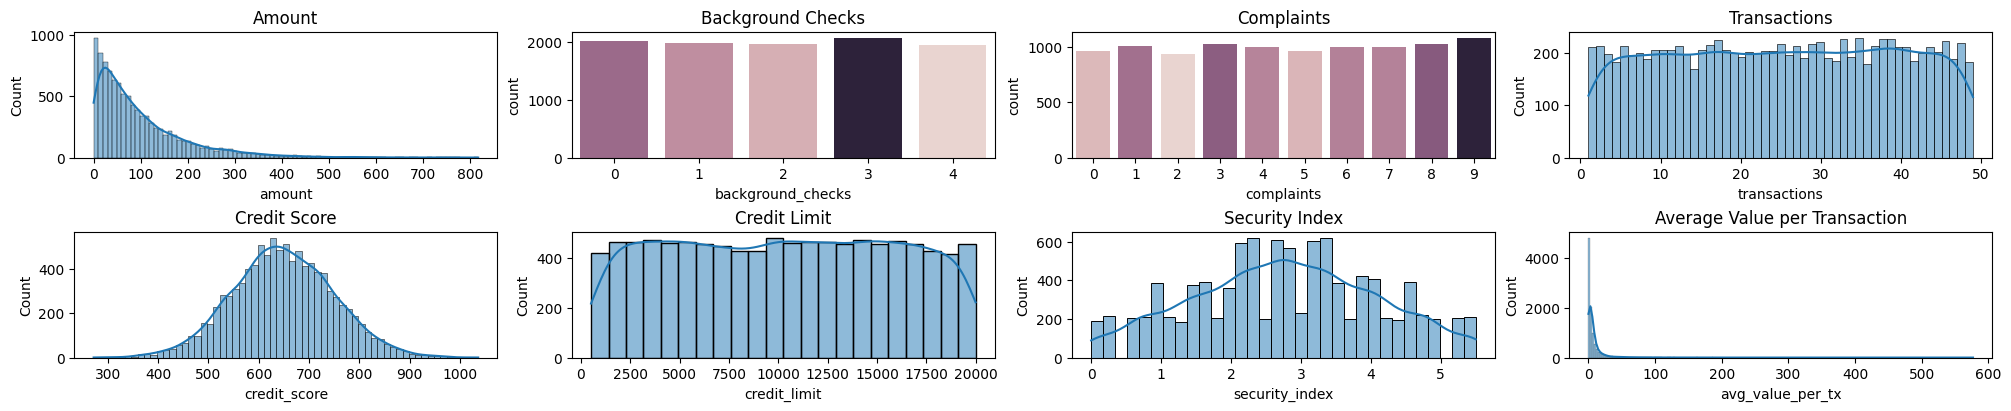

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 4, figsize=(20, 4), constrained_layout=True)

sns.histplot(data=raw_df, x="amount", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Amount")

sns.barplot(data=raw_df['background_checks'].value_counts().reset_index(), x="background_checks", y="count", hue="count", legend=False, ax=axes[0, 1])
axes[0, 1].set_title("Background Checks")

sns.barplot(data=raw_df['complaints'].value_counts().reset_index(), x="complaints", y="count", hue="count", legend=False, ax=axes[0, 2])
axes[0, 2].set_title("Complaints")

sns.histplot(raw_df['transactions'], bins=len(raw_df['transactions'].drop_duplicates()), kde=True, ax=axes[0, 3])
axes[0, 3].set_title("Transactions")

sns.histplot(data=raw_df, x="credit_score", kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Credit Score")

sns.histplot(data=raw_df, x="credit_limit", kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Credit Limit")

sns.histplot(data=raw_df, x="security_index", kde=True, ax=axes[1, 2])
axes[1, 2].set_title("Security Index")

sns.histplot(data=raw_df, x="avg_value_per_tx", kde=True, ax=axes[1, 3])
axes[1, 3].set_title("Average Value per Transaction")

plt.show()

The "Amount" and "Average Value per Transaction" distributions shows a right-skewed pattern, with most transactions clustered at lower values and a short peak extending toward higher amounts. This indicates that while most transactions are relatively small, there are a small number of high-value transactions that could be of particular interest for fraud detection analysis.

In [136]:
import plotly.express as px
px.box(raw_df['avg_value_per_tx'], width=400, title="Outliers in Average Transaction Value")

As we know, in fraud datasets, fraudulent transactions tend to:

- be small (test transactions), or
- be very high (cash-out quickly).

So let's keep these outliers for now.

Checking the distribution of categorical variables:

In [137]:
cat_cols = ['country', 'city', 'district', 'os', 'device', 'browser']
for col in cat_cols:
    print(f"{col}: {raw_df[col].nunique()} in {raw_df[col].shape[0]}")

country: 4 in 10000
city: 5 in 10000
district: 5 in 10000
os: 4 in 10000
device: 2 in 10000
browser: 4 in 10000


## 5. Variables encoding

Since we have a few classes, we will use one-hot encoding to encode categorical variables.

In [138]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(raw_df[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

encoded_df.head()

,country_Brazil,country_Germany,country_UK,country_USA,city_Berlin,city_London,city_New York,city_Rio,city_Unknown,district_Center,...,os_Android,os_Unknown,os_Windows,os_iOS,device_desktop,device_mobile,browser_Chrome,browser_Edge,browser_Firefox,browser_Safari
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [139]:
# Merge encoded columns back
df = pd.concat([raw_df.drop(columns=cat_cols), encoded_df], axis=1)

pd.set_option('display.max_columns', None)
display(df.shape)
display(df.head())

(10000, 39)

,transaction_id,amount,zip,ip,background_checks,complaints,transactions,credit_score,credit_limit,is_fraud,time,day,hour,security_index,avg_value_per_tx,country_Brazil,country_Germany,country_UK,country_USA,city_Berlin,city_London,city_New York,city_Rio,city_Unknown,district_Center,district_North,district_South,district_Unknown,district_West,os_Android,os_Unknown,os_Windows,os_iOS,device_desktop,device_mobile,browser_Chrome,browser_Edge,browser_Firefox,browser_Safari
0,0,46.93,23849,192.168.146.74,1,7,47,606,14481.56,0,0,1,0,2.8,0.998511,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,301.01,29344,192.168.216.0,1,2,24,512,11436.06,0,471,1,0,1.3,12.542083,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,131.67,31214,192.168.159.212,0,8,46,751,15843.76,0,751,1,0,2.4,2.862391,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3,91.29,48226,192.168.108.76,3,4,16,611,12256.27,0,1270,1,0,3.3,5.705625,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,16.96,32522,192.168.161.16,4,5,29,764,19257.12,0,1698,1,0,4.3,0.584828,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## 6. Numerical features standardization and dimensionality reduction

Many machine learning estimators does not perform well when the individual features do not more or less look like standard normally distributed data. As a good practice, we should standardize the numerical features and reduce their dimensionality.

In this approach, we will use the `StandardScaler` from `sklearn.preprocessing` to standardize the numerical features and the `PCA` from `sklearn.decomposition` to reduce features dimensionality.

To gain interpretability, we will leave the variables "amount" and "time" in their original form, without applying PCA to them.

In [140]:
# Scale numerical features
num_cols = df.drop(columns=['amount', 'time', 'transaction_id', 'zip', 'ip', 'is_fraud']).select_dtypes(include=np.number).columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

display(df_scaled.shape)
display(df_scaled.head())

(10000, 39)

,transaction_id,amount,zip,ip,background_checks,complaints,transactions,credit_score,credit_limit,is_fraud,time,day,hour,security_index,avg_value_per_tx,country_Brazil,country_Germany,country_UK,country_USA,city_Berlin,city_London,city_New York,city_Rio,city_Unknown,district_Center,district_North,district_South,district_Unknown,district_West,os_Android,os_Unknown,os_Windows,os_iOS,device_desktop,device_mobile,browser_Chrome,browser_Edge,browser_Firefox,browser_Safari
0,0,46.93,23849,192.168.146.74,-0.704775,0.840790,1.551399,-0.422273,0.759703,0,0,-1.394077,-1.655379,0.024643,-0.334593,-0.570268,-0.577812,1.727904,-0.582585,1.745081,-0.573039,-0.569344,-0.567034,-0.13346,-0.582893,1.802746,-0.563954,-0.162088,-0.568420,1.433307,-0.160784,-0.701969,-0.681742,1.018572,-1.018572,1.750254,-0.571962,-0.585819,-0.580276
1,1,301.01,29344,192.168.216.0,-0.704775,-0.890014,-0.078222,-1.359700,0.215236,0,471,-1.394077,-1.655379,-1.114470,0.145151,-0.570268,1.730666,-0.578736,-0.582585,-0.573039,-0.573039,1.756408,-0.567034,-0.13346,-0.582893,1.802746,-0.563954,-0.162088,-0.568420,-0.697687,-0.160784,-0.701969,1.466830,1.018572,-1.018572,1.750254,-0.571962,-0.585819,-0.580276
2,2,131.67,31214,192.168.159.212,-1.413377,1.186951,1.480546,1.023758,1.003234,0,751,-1.394077,-1.655379,-0.279121,-0.257132,-0.570268,1.730666,-0.578736,-0.582585,-0.573039,-0.573039,-0.569344,1.763562,-0.13346,-0.582893,-0.554709,-0.563954,-0.162088,1.759262,-0.697687,-0.160784,1.424565,-0.681742,-0.981766,0.981766,1.750254,-0.571962,-0.585819,-0.580276
3,3,91.29,48226,192.168.108.76,0.712428,-0.197692,-0.645046,-0.372410,0.361871,0,1270,-1.394077,-1.655379,0.404347,-0.138968,-0.570268,-0.577812,-0.578736,1.716488,1.745081,-0.573039,-0.569344,-0.567034,-0.13346,1.715581,-0.554709,-0.563954,-0.162088,-0.568420,-0.697687,-0.160784,-0.701969,1.466830,-0.981766,0.981766,-0.571346,1.748369,-0.585819,-0.580276
4,4,16.96,32522,192.168.161.16,1.421030,0.148468,0.276044,1.153403,1.613466,0,1698,-1.394077,-1.655379,1.163756,-0.351786,1.753562,-0.577812,-0.578736,-0.582585,-0.573039,-0.573039,-0.569344,1.763562,-0.13346,1.715581,-0.554709,-0.563954,-0.162088,-0.568420,-0.697687,-0.160784,-0.701969,1.466830,-0.981766,0.981766,-0.571346,-0.571962,1.707013,-0.580276


In [141]:
# PCA for dimensionality reduction
pca = PCA(n_components=20)
pca_features = pca.fit_transform(df_scaled[num_cols])

df_pca = pd.DataFrame(
    pca_features, 
    columns=[f'pca_{i+1}' for i in range(20)]
    )

# Combine PCA features + target
final_df = pd.concat([df_pca, df_scaled[['amount', 'time', 'is_fraud']].reset_index(drop=True)], axis=1)

print("\nPreprocessed dataframe sample:")
display(final_df)


Preprocessed dataframe sample:


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,amount,time,is_fraud
0,-0.805956,1.340173,-1.115536,-1.013537,2.548372,-1.236885,-0.106279,0.286358,-0.808425,0.429308,-1.046590,0.049307,2.159205,0.204893,-1.168304,-0.082249,1.273493,0.864439,0.507154,-0.609541,46.93,0,0
1,-2.007404,0.533557,-0.353556,1.390186,-0.102937,-0.781012,1.875275,0.051302,0.710010,-0.171021,-0.087460,0.241366,0.581821,2.511077,-1.937125,-1.540837,0.750973,0.663240,-0.263117,-0.701367,301.01,471,0
2,0.538757,-1.280568,1.669992,-0.532773,0.944214,-0.513243,0.485485,-0.285630,2.305758,0.334084,-2.021105,1.393418,-0.603411,0.039839,-0.714680,-1.808992,-1.292435,0.416254,0.732805,-0.470503,131.67,751,0
3,1.063155,-0.719889,0.001865,1.324079,-1.536637,0.380662,-0.529162,-2.177460,-1.915565,0.520193,-1.255580,-0.603202,-0.070782,0.481216,-0.338307,1.841763,0.208670,0.670912,-0.084437,-0.296673,91.29,1270,0
4,2.100038,-0.131608,-1.262390,1.617623,-0.502977,1.714881,0.426261,-1.241893,1.500744,-0.725877,-0.162619,-0.327258,-0.950107,-2.320577,-0.829562,-0.064768,0.713551,0.422466,-0.092602,-0.407868,16.96,1698,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.137847,1.581078,2.255579,-0.509830,1.565416,-0.106506,-0.949261,-0.889901,1.785002,-0.824146,-0.495419,0.003745,-0.590566,2.557558,-0.112160,0.532363,0.038552,-0.120308,-0.153515,-0.222193,194.95,22030,0
9996,-0.882909,1.155594,0.874885,-0.732823,-0.958020,0.830584,-1.343153,0.198443,1.269726,1.060260,-1.806352,0.141841,0.972699,1.958295,-0.512034,1.781971,0.328014,4.992629,3.327986,-0.128133,227.80,22315,0
9997,-0.550996,1.327709,2.266026,-0.478419,-0.368872,-0.088214,-1.674225,-1.376904,-1.275744,-0.148605,2.081340,0.963912,0.276356,0.069951,0.524001,-0.297510,-1.231372,0.212540,-0.043491,0.003699,293.20,22521,0
9998,-1.040651,1.037252,1.632002,-0.640637,0.293950,-0.730291,1.990509,0.568280,0.444979,-0.107622,0.268171,-0.132944,-0.055354,2.134773,-1.857892,-1.703325,0.600825,-0.090474,0.437463,-0.407681,50.66,22646,0


## 7. Saving the preprocessed data

Now we can save the preprocessed data to a CSV file.

In [13]:
os.makedirs("data", exist_ok=True)
final_df.to_csv(os.path.join("data", "bank_transactions_processed.csv"), index=False)